In [1]:
import tensorflow as tf
import numpy as np
from helpers import pre_process_input_data, convert_tweets_to_bert_embedding, generate_transfer_learn_classifier,generate_fine_tune_model,pre_process_bert_inputs,plot_history #See end of notebook for implementation of these functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Further Investigation into sentiment Anaylsis with Fine Tuning Bert and Custom Embeddings
##### Team: Alex Shockley, Will Landin, Rick Lattin Repo: https://github.com/lattiric/ML_NN_Proj_02

[2.0 points] Give an overview of the dataset you have chosen to use.

What is the classification task. Is this multi-task? Explain.
What is the feature data? Who collected the data? Why? When? Is the data multi-modal?
What evaluation criteria will you be using and why? 

### Dataset Overview
We are using the Sentiment 140 Tweets dataset that was collected and shown on Kaggle. The dataset was organized on Kaggle by Levi Klein and it has sentiment scores as either positive or negative that was curated from Twitter. https://www.kaggle.com/datasets/kazanova/sentiment140/discussion/454347. Of the 1.6 million tweets we decided to scope it down to around 150,000 examples of each positive and negative, making it 300,000 tweets total. Levi Klein on kaggle described the theoretical accuracy of the dataset itself at around 80%. This is an excerpt from him:

>" Any classifier we use will be trained as a binary classifier, and will be unable to classify data points as having a neutral sentiment, so we can conclude that a "perfect" classifier will essentially be randomly guessing the sentiment of neutral tweets that >have been mislabeled as either positive or negative. Therefore, even a "perfect" classifier will only correctly "guess" the classification of about 50% of the mislabeled tweets on average. As a result, we can conclude that the maximum attainable accuracy of a >binary classifier on this dataset will be about 60% + 10% + 10% = 80%. Of course, it is good to remember that we estimated the distribution of our mislabeled tweets from a sample, so our true maximum attainable accuracy might not be exactly 80%. Suffice to >say, the maximum attainable accuracy using this dataset will be approximately 80%"

The classification is not a multi task nor is the data multi modal. We are given 300,000 tweets as text and 300,000 binary labels (either 0 or 1) as integers. The task for the model is simply a binary classifier for sentiment, either the tweet is positive or negative, we utilize a sigmoid on our outputs as to map the values between 0 and 1, but it is important to note that this allows for our model to output continous values (ie. 0.5) for the text. The evaluation criteria that we will be looking at is accuracy because we have a perfectly balanced dataset (as all things should be) and we care about classifying each of the classes equally, True positives and True negatives are more important to us that false negatives and false positives. The reason that we believe that the false positives and false negatives are not of much concern is because of the nature of the task being sentiment analysis and we assume that no critical decisions will be made off of our model's predictions. 

Due to Levi Klein's analysis on the dataset, we are aiming for around, or better than, 80% validation accuracy.

[2.0 points] Describe the foundational model that you will be using to transfer learn from. What tasks was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc

The foundational model that we used to transfer learn from is Google’s famous language model BERT. BERT stands for Bidirectional Encoder Representation from Transformers and it was developed in 2018 for the purpose of tackling numerous common NLP tasks. It consists of 12 encoder layers, each containing 12 attention heads per layer. One of the tasks was sentiment analysis, and we decided to implement BERT for this exact reason. Our task is to perform sentiment analysis on a data set of tweets that have been labeled as positive or negative, and since BERT has consistently performed exceedingly well at sentiment analysis tasks, it made sense to use it. Although it excels at sentiment analysis, it was pre trained on the tasks of masked language modeling (MLM) and next sentence prediction (NSP) using the bidirectionality that earned BERT its namesake. These tasks are very similar to sentiment analysis in that the context of the text, and not just the individual words are needed to complete the tasks. Therefore it is extremely applicable from the original training tasks. BERT was pretrained on BookCorpus which consists of 11,038 unpublished books and English Wikipedia, as well as 4 TPUs and one million steps with a batch size of 256. Adam was the optimizer and the learning rate was 1e-4 with 10,000 learning rate warm up steps and a linear decay of learning rate after that. (Also we had experience using it for the last lab and it performed extremely well so we wanted to reuse it(and the code we already had written 😏))

Sources used:
- https://huggingface.co/google-bert/bert-base-uncased
- https://huggingface.co/blog/bert-101
- https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model#:~:text=Google%20developed%20BERT%20to%20serve,models%20are%20made%20to%20do.

[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

For creating the train test split, we split the data in an 80/20 split, as we are doing a generic classification task with 500,000 data entries. We made sure to stratify the data correctly, evenly distributing the positive and negative tweets evenly between all train and test groups. The distribution only needed to be 50% positive and 50% negative as the data only classified each tweet as positive or negative, and had no neutral distinction. `sklearn`'s `train_test_split` function was perfect for this use case and required the least amout of overhead on our end so that is the method we ended up using.

In [2]:
TWEET_FILEPATH = '/mnt/c/Users/alexs/ML/data/concept_net/tweets.csv'
raw_tweet_data = pre_process_input_data(TWEET_FILEPATH,num_samples=150000) #Grab 250,000 of each class (positive and negative sentiment)
raw_tweet_data.head()

,target,text
574913,0,@peterfacinelli i'm trying really hard to win ...
262269,0,damn im missing all of this but i taped it.
3878,0,"Did not sleep well at all, and have a very unh..."
736702,0,Day of unpacking
308513,0,i wanna talk wit sum1


In [3]:
raw_tweet_data.groupby('target').count()

,text
target,
0,150000
1,150000


In [4]:
train_data,test_data,train_targets,test_targets = train_test_split(raw_tweet_data['text'].to_numpy(),raw_tweet_data['target'].to_numpy(),test_size=0.2)
print(f"""
    train_data shape: {train_data.shape}
    train_targets shape: {train_targets.shape}
    test_data shape: {test_data.shape}
    test_targets shape: {test_targets.shape}
      """)


    train_data shape: (240000,)
    train_targets shape: (240000,)
    test_data shape: (60000,)
    test_targets shape: (60000,)
      


In [5]:
# np.unique(test_targets,return_counts=True) #They are evenly split
# np.unique(train_targets,return_counts=True)

# Model From Scratch

[2.0 points] Train a model from scratch to perform the classification task (this does NOT need to be a transformer). That is, do not use transfer learning for the classification task. Verify the model converges (even if the model is overfit). This does NOT need to mirror the foundational model. This model may be far less computational to train.

The trained from scratch model is a CNN that contains an embedding layer, a single one dimension convolution layer and a dense layer with a single layer as output. We originally attempted to train a transformer from scratch, but in the process of creating custom embeddings for the transformer using a CNN, we discovered that the CNN seemed to be better at the sentiment analysis task than the transformer (for this specific dataset). As a result, we decided to use the CNN as our sole “trained from scratch” model. Evidently, part of the reason that the CNN performed so well was because of the embedding layer. It was given an embedding size of 300 which resulted in the embedding layer containing around 59.6 million parameters. This made it by far the most computationally intensive aspect of the CNN model, but due to the odd language usage that permeates the tweet dataset that we used, we believe this massive embedding layer was integral in handling this strange language.

In [6]:
def clean_tweet(tweet):
    # Remove any non-alphabetic characters except basic punctuation
    tweet = re.sub(r"[^a-zA-Z0-9.,'!? ]", '', tweet)
    # Remove any excess whitespace
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet


In [7]:
X_train = np.array([clean_tweet(t) for t in train_data])
X_test = np.array([clean_tweet(t) for t in test_data])

y_train = train_targets.copy()
y_test = test_targets.copy()

In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = np.max([len(tweet) for tweet in X_train]) # maximum number of words in a tweet

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_ART_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_ART_LEN)


#y_ohe = keras.utils.to_categorical(y_train, num_classes=2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_train.shape)
print(np.max(X))

Found 198550 unique tokens. Distilled to 198550 top words.
Shape of data tensor: (240000, 169)
Shape of label tensor: (240000,)
198550


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract, Concatenate
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

# Parameters for embedding layer
VOCAB_SIZE = len(word_index) + 1  # Add 1 for padding
EMBED_SIZE = 300  # You can change this size according to your preference

# Create model
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_ART_LEN))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
# model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dropout(0.5))
# model.add(Dense(32,activation='sigmoid'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile model
#make learning rate in adam optimizer smaller
adam_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

#early stopping from val_loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.001)

model.compile(optimizer= adam_optimizer, loss='mse', metrics=['accuracy'])

# Print summary
model.summary()

# Train the model
embed_hist = model.fit(X, y_train, epochs=25, batch_size=512, validation_data=(X_test, y_test), callbacks=early_stopping)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Once the model is trained, you can retrieve the learned embedding weights
embedding_weights = model.layers[0].get_weights()[0]
print("Embedding weights shape:", embedding_weights.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 169, 300)          59565300  
                                                                 
 conv1d (Conv1D)             (None, 167, 128)          115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 dropout_37 (Dropout)        (None, 4224)              0         
                                                                 
 dense (Dense)               (None, 1)                 4225      
                                                        

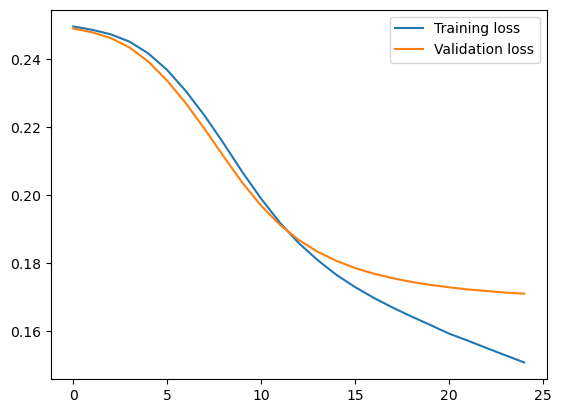

In [10]:
plot_history(embed_hist.history,'loss') #Plot embedding loss as its training

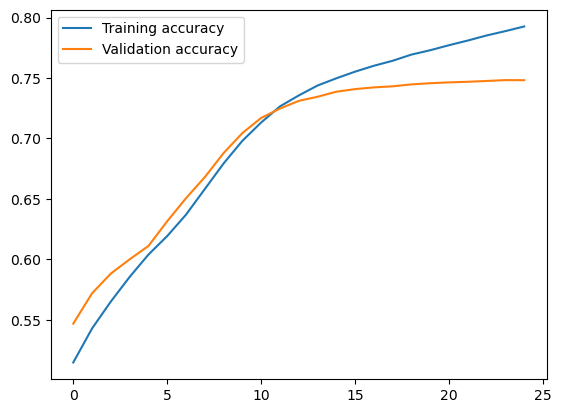

In [58]:
plot_history(embed_hist.history,'accuracy')

As we can see from the above graph, the training and validation losses are beginning to plateau and the model is converging around a 0.18 validation loss. The accuracy on the test set was around 0.74 which is decent, but not an amazing accuracy. We could have let the model train for longer, but given time constraints and the fact that the validation loss was plateauing, we are pretty happy with how this model turned out

In [11]:
sample_preds = model(X_test[0:15])
for pred,txt in zip(sample_preds,test_data[0:15]):
    print(f'Prediction: {(pred[0])} | Text: {txt}')

Prediction: 0.8920257091522217 | Text: @csharpzealot hehehe you're giving me ideas 
Prediction: 0.546600341796875 | Text: Now is 3.43pm and faci haven finish his lesson...always liddat... 
Prediction: 0.08219126611948013 | Text: Seeing land of the lost cuz all the hangovers are sold out 
Prediction: 0.6064983606338501 | Text: @MrNateJackson I interjected your name into my Facebook status...I was runnin' out of room on twitter, sorry 
Prediction: 0.780858039855957 | Text: @nicknye  im not a rap fan but have met Mason before &amp; appreciate his ministry. I'll be praying for his church &amp; the restoration of Ambas
Prediction: 0.26082977652549744 | Text: Right, I'm at work for 7 hours... Anyone wanna tweet chat? 
Prediction: 0.7909603714942932 | Text: New week...  work in progresssssssssss
Prediction: 0.8234612345695496 | Text: Finished watching Underworld: The Rise of the Lycans 
Prediction: 0.004607122391462326 | Text: mommaTANIS is feeling horrible and she feels horrible...gah! i nee

Above we can see some examples of what the model predicted the sentiment scores along with the associated sentence that it was given as input.

In [12]:
y_hat_from_scratch = np.round(model.predict(X_test)) # This will be used for the mcnemar tests later on

1875/1875 [==============================] - 2s 960us/step


[2.0 points] Train a model by transfer learning from your foundational model. Verify that the new model converges. You only need to train a model using the bottleneck features for this step. 

In order to not be "the one group who only puts a single dense layer for transfer learning" we decided to put two dense layers and a final output layer as our bottleneck transfer learn architecture. This was our favorite model over all because it took MUCH less time to train than its competitors. In reality, we chose this structure because it was very fast to train and because we saw a pretty good result from it when we used the same archeticture in the previous lab where we were also transfer learning from Bert. There are a total of 102,593 trainable parameters and a single dropout with a 0.5 probability of dropping connections.

# Bottleneck Transfer Learning

In [14]:
mdl = generate_transfer_learn_classifier()
mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         98432     
                                                                 
 dropout_38 (Dropout)        (None, None, 128)         0         
                                                                 
 dense_2 (Dense)             (None, None, 32)          4128      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 102,593
Trainable params: 102,593
Non-trainable params: 0
_________________________________________________________________


In [15]:
tf.keras.backend.clear_session()
X_train_bottleneck = convert_tweets_to_bert_embedding(train_data,batch_size=500) 
X_test_bottleneck = convert_tweets_to_bert_embedding(test_data,batch_size=500) 

Grabbing BERT Embeddings with padding to 369 characters


  0%|          | 0/480 [00:00<?, ?it/s]

Grabbing BERT Embeddings with padding to 296 characters


  0%|          | 0/120 [00:00<?, ?it/s]

In [16]:
print(f"""
      X_train shape :{X_train_bottleneck.shape}
      X_test shape :{X_test_bottleneck.shape}
      """)


      X_train shape :(240000, 768)
      X_test shape :(60000, 768)
      


In [17]:
hist = mdl.fit(X_train_bottleneck,train_targets,validation_data=(X_test_bottleneck,test_targets),epochs=100,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,min_delta=0.001)]) #13 mins

Epoch 1/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4826 - accuracy: 0.7689 - val_loss: 0.4557 - val_accuracy: 0.7865
Epoch 2/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4614 - accuracy: 0.7822 - val_loss: 0.4501 - val_accuracy: 0.7892
Epoch 3/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4545 - accuracy: 0.7861 - val_loss: 0.4654 - val_accuracy: 0.7833
Epoch 4/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4504 - accuracy: 0.7886 - val_loss: 0.4552 - val_accuracy: 0.7919
Epoch 5/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4469 - accuracy: 0.7907 - val_loss: 0.4532 - val_accuracy: 0.7935
Epoch 6/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4442 - accuracy: 0.7929 - val_loss: 0.4486 - val_accuracy: 0.7972
Epoch 7/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4428 - accuracy: 0.7928 - val_loss: 0.4534 -

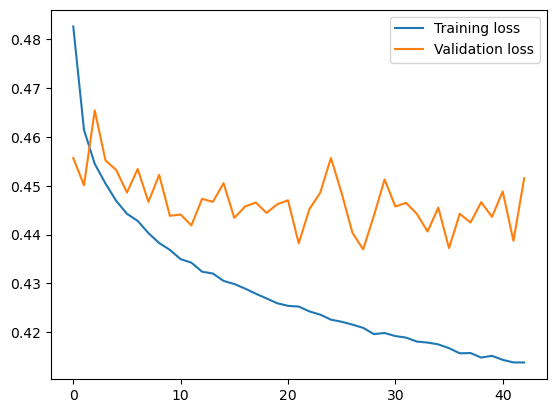

In [18]:
plot_history(hist.history,'loss')

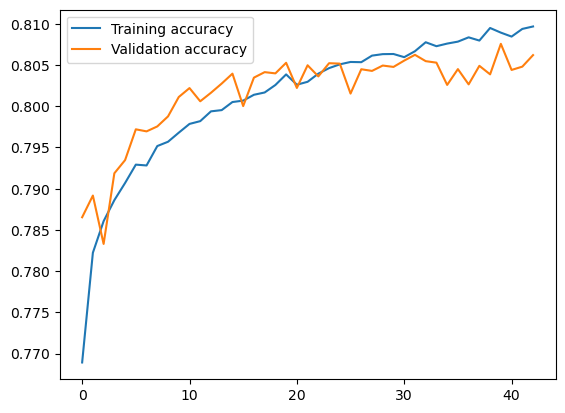

In [59]:
plot_history(hist.history,'accuracy')

From the plots above, we can conclude that, even the validation loss is oscilating up and down, it is consistently around 0.45 and does not appear to be getting any better. The training loss is also plateauing and we can conclude that this model has converged.

In [19]:
y_hat_bottleneck = np.round(mdl.predict(X_test_bottleneck))


1875/1875 [==============================] - 2s 884us/step


# Fine Tune Network

In [20]:
from helpers import bert_model
from helpers import bert_tokenizer

def generate_base_model():
    
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="token_type_ids")
    for l in bert_model.bert.encoder.layer:
        l.trainable = False
    bert_model.bert.embeddings.trainable = False
    # bert_model.bert.trainable = False
    bert_model.bert.encoder.layer[-1].trainable = True
    # BERT model
    bert_model.bert.pooler.trainable = False
    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    print(outputs)
    # Extract the last hidden state
    pooled_output = outputs.last_hidden_state[:,0,:]

    # Define model
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=pooled_output)

    return model
base_model = generate_base_model()

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, None, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [21]:
base_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [22]:

fine_tune_model = tf.keras.Model(inputs=base_model.inputs,outputs=mdl(base_model.output))

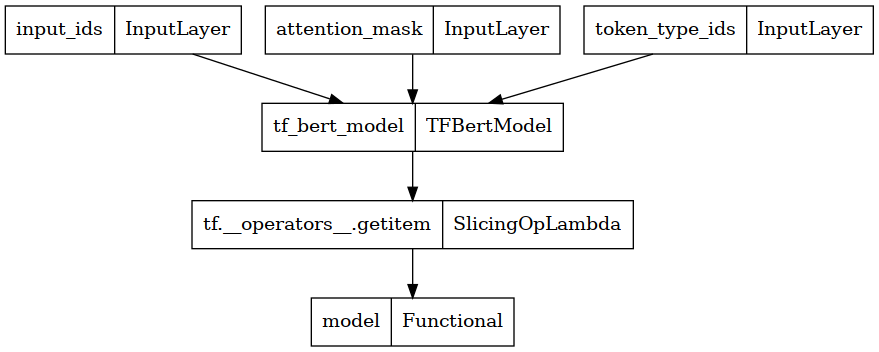

In [23]:
tf.keras.utils.plot_model(fine_tune_model)

In [24]:
fine_tune_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',   

In [25]:
x_train,y_train = pre_process_bert_inputs(train_data,train_targets)
x_test,y_test = pre_process_bert_inputs(test_data,test_targets)

In [26]:
fine_tune_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.mean_squared_error,
    metrics=['accuracy']
)

In [27]:
fine_tune_hist = fine_tune_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=0.001)]) # 64mins

Epoch 1/5
7500/7500 [==============================] - 766s 101ms/step - loss: 0.1420 - accuracy: 0.7959 - val_loss: 0.1298 - val_accuracy: 0.8207
Epoch 2/5
7500/7500 [==============================] - 763s 102ms/step - loss: 0.1329 - accuracy: 0.8110 - val_loss: 0.1267 - val_accuracy: 0.8268
Epoch 3/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1287 - accuracy: 0.8178 - val_loss: 0.1247 - val_accuracy: 0.8316
Epoch 4/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1258 - accuracy: 0.8221 - val_loss: 0.1243 - val_accuracy: 0.8316
Epoch 5/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1236 - accuracy: 0.8254 - val_loss: 0.1222 - val_accuracy: 0.8331


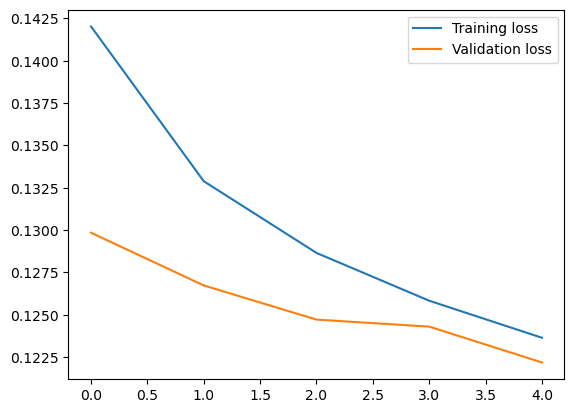

In [28]:
plot_history(fine_tune_hist.history,'loss')

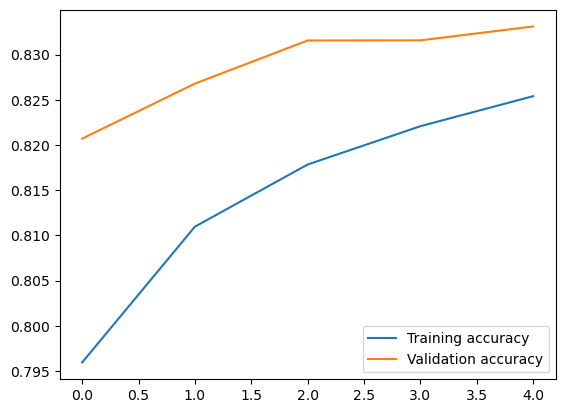

In [60]:
plot_history(fine_tune_hist.history,'accuracy')

You might be thinking that these graphs look a bit backwards. And I am inclined to agree. The main driver for why these graphs are different from the bottleneck training graphs is the fact that the bottleneck network had a loss function of binary cross entropy. We decided to make a switch to mean squared error because we did not 1 hot encode the target values and from what we understood about binary cross entropy (Alex Shockley heard Dr. Larson say it is a weird calculation when its not 1 hot encoded), we made a switch to mse. We missed the fact that the bottle neck network was trained using binary cross entropy loss and due to time constraints, we decided to leave it in and discuss it here. The model was starting to converge, but considering we were having to backpropagate through an entire encoder layer in bert, we were unable to continue running the model more than 5 epochs (it took 13 mins per epoch). Overall though, the fine tuning of the model led to a 3% higher accuracy when compared to our bottleneck model and a 9% accuracy over the from scratch cnn that we made which makes it the longest to train, but also the most accurate model.

In [29]:
y_hat_fine_tune = np.round(fine_tune_model.predict(x_test))

1875/1875 [==============================] - 99s 52ms/step


In [40]:
from statsmodels.stats.contingency_tables import mcnemar

from_scratch_preds = y_hat_from_scratch.flatten() == test_targets.flatten()
bottleneck_preds =  y_hat_bottleneck.flatten() == test_targets.flatten()
finetune_preds =  y_hat_fine_tune.flatten() == test_targets.flatten()
# transformer_preds =  y_hat_transfromer_from_scratch.flatten() == test_targets.flatten()
# correct_pred3 = np.argmax(yhat_t3, axis=1) == np.argmax(y_test, axis=1)


def calculate_mcnemar(correct1, correct2):
    # Count the number of times each model was correct/incorrect
    n00 = n01 = n10 = n11 = 0
    for i in range(len(correct1)):
        if correct1[i] and correct2[i]:
            n11 += 1
        elif correct1[i] and not correct2[i]:
            n10 += 1
        elif not correct1[i] and correct2[i]:
            n01 += 1
        elif not correct1[i] and not correct2[i]:
            n00 += 1
    
    # Construct the contingency table
    table = [[n11, n10],
             [n01, n00]]
    
    # Perform McNemar's test
    result = mcnemar(table, exact=False, correction=True)  # Use correction for small sample sizes
    return result

# Calculate McNemar's test
# result1_2 = calculate_mcnemar(correct_pred1, correct_pred2)
# result1_3 = calculate_mcnemar(correct_pred1, correct_pred3)
# result2_3 = calculate_mcnemar(correct_pred2, correct_pred3)
res_scratch_bottleneck = calculate_mcnemar(from_scratch_preds,bottleneck_preds)
res_scratch_finetune = calculate_mcnemar(from_scratch_preds,finetune_preds)
res_finetune_bottleneck = calculate_mcnemar(finetune_preds,bottleneck_preds)


print(f'From Scratch(CNN) Vs. Bottleneck (Bert): stat={res_scratch_bottleneck.statistic}, p-value={res_scratch_bottleneck.pvalue}')
print(f'From Scratch(CNN) Vs. FineTune (Bert): stat={res_scratch_finetune.statistic}, p-value={res_scratch_finetune.pvalue}')
print(f'Bottleneck (Bert) Vs. FineTune (Bert): stat={res_finetune_bottleneck.statistic}, p-value={res_finetune_bottleneck.pvalue}')


From Scratch(CNN) Vs. Bottleneck (Bert): stat=875.0921309343161, p-value=2.550213185774605e-192
From Scratch(CNN) Vs. FineTune (Bert): stat=2046.2767920511, p-value=0.0
Bottleneck (Bert) Vs. FineTune (Bert): stat=450.13304498269895, p-value=6.747786316450042e-100


Each result of the mcnemar test shows our p-value far below 0.05 and statistic values much much higher than 3.84.

Therefore, we can conclude with a high degree of confidence that All 3 of our models are statistically different. 2 and 3 were the closest but were still statistically different to each other. This makes sense to use because the Fine-Tuned Model was built off the Bottleneck. The Fine-Tuned Model and the CNN had the largest difference. All three Models were statistically different.

Reference: McNemar, Q. (1947). Note on the sampling error of the difference between correlated proportions or percentages. Psychometrika, 12(2), 153–157. https://doi.org/10.1007/bf02295996

### Model Final Comparison of Accuracay and Times
This test doesn't tell us which model is superior; for that, we have investigated the actual performance metrics (accuracy) for our different architectures.

Training times
- CNN: 3 Minutes, 6 seconds an Epoch, %74 Validation Accuracy
- Bottleneck: 13 Minutes, 18 seconds an Epoch, 80% Validation Accuracy
- ***Fine-Tune: 65 Minutes, 13 minutes an Epoch, 83% Validation Accuracy***
- Additionally, we saw that the transformer that we trained from scratch (see below) had an 78.7% accuracy but appears to have overfit to the training set so we did not include it here




We see that by a solid 3%, The Fine-Tuned Model had the best validation accuracy. But this doesn't take into account the time it took to train.

# Additional Information

## Transformer from Scratch

We started by using a transformer without custom embeddings, but our model was performing poorly with low accuracies so we decided that it would be interesting to create our own Embeddings using the CNN. Funnily enough, the CNN we used to train the models was the one we decided to use in this lab due to how well the CNN trained, did not converge, and had decent accuracy. 

Below is the code we used to create our Encoder-Only transformer to use for Sentiment Analysis. Our Transformer overfits very quickly only after the first epoch, and even though it had a higher accuracy of around 78.8% validation accuracy, it took 5x as long to train than the CNN. We have taken the weights from our CNN to use in the Position and Encoding Layer and we have frozen those weights

In [30]:
EMBED_SIZE = 300
print('Found %s word vectors.' % len(embedding_weights))

# Now fill in the matrix using the ordering from the keras word tokenizer
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embedding_weights[i]  # Use the learned embeddings
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words += 1

print("Embedding Shape:", embedding_matrix.shape, "\n",
      "Total words found:", found_words, "\n",
      "Percentage:", 100 * found_words / embedding_matrix.shape[0])

Found 198551 word vectors.
Embedding Shape: (198551, 300) 
 Total words found: 198550 
 Percentage: 99.99949635106346


In [31]:
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)

        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

class CustomTokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(len(word_index)+1,
                                   EMBED_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=MAX_ART_LEN)
        self.token_emb.trainable=False
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [53]:
embed_dim = 300  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
top_words = 100
NUM_CLASSES =  1

adam_optimizer = tf.optimizers.Adam(learning_rate=1e-5)
inputs = Input(shape=(X_train.shape[1],))
x = CustomTokenAndPositionEmbedding(X_train.shape[1], top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
xformer = Model(inputs=inputs, outputs=outputs)
model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())
xformer.compile(optimizer=adam_optimizer,
                      loss='mse',
                      metrics=['accuracy'])
history = xformer.fit(
    X_train, y_train, batch_size=512, epochs=7,
    validation_data=(X_test, y_test)
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 169)]             0         
                                                                 
 custom_token_and_position_e  (None, 169, 300)         59616000  
 mbedding_1 (CustomTokenAndP                                     
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Transf  (None, 169, 300)         2186432   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 300)               0   

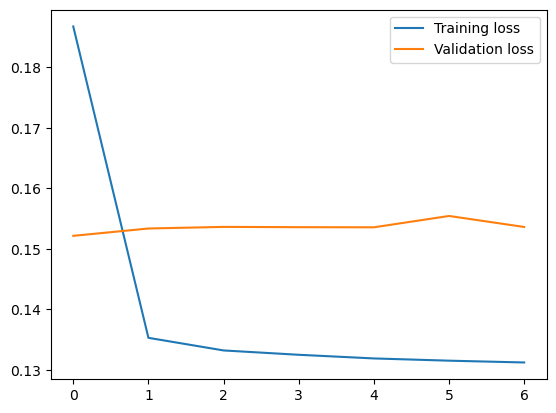

In [54]:
plot_history(history.history,'loss')

In [34]:
y_hat_transfromer_from_scratch = np.round(xformer.predict(X_test))

1875/1875 [==============================] - 5s 2ms/step


In [35]:
# y_hat_transfromer_from_scratch.shape

In [36]:
y_test

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 0, 1])>

## helpers.py

In [ ]:
"""
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime
from tqdm.auto import tqdm
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def pre_process_input_data(filepath='./data/concept_net/tweets.csv',encoding='cp1252',num_samples=None,random_state=None): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    if num_samples:
        tweets = tweets.groupby('target').sample(num_samples,random_state=random_state)

    return tweets

def convert_tweets_to_bert_embedding(text_arr:np.ndarray,batch_size=500):
        batches = [(i,min(i+batch_size,len(text_arr))) for i in range(0,len(text_arr),batch_size)] #Split into smaller chunks

        # _df = pd.DataFrame()
        max_twt_len = np.max([len(v) for v in text_arr])

        res = []
        print(f'Grabbing BERT Embeddings with padding to {max_twt_len} characters')
        for lower,upper in tqdm(batches):
            chunk = text_arr[lower:upper]
            features = bert_tokenizer(chunk.tolist(),padding='max_length', truncation=True, return_tensors='tf',max_length=max_twt_len)
            features = bert_model(**features).last_hidden_state[:,0,:]
            # chunk['features'] = features.numpy().tolist()
            res.append(features.numpy())
        return np.array(res).reshape(-1,768) # Reshape to output numrows by embedding space

def generate_transfer_learn_classifier():
    inputs = tf.keras.layers.Input(shape=(None,768))

    x = tf.keras.layers.Dense(128,activation = 'relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs],outputs=x)
    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

    return model

def plot_history(hist,metric,show_val=True):
    plt.plot(hist[f'{metric}'])
    if show_val:
        plt.plot(hist[f'val_{metric}'])
        plt.legend([f'Training {metric}',f'Validation {metric}'])  
    plt.show()

def generate_fine_tune_model():
    
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="token_type_ids")
    for l in bert_model.bert.encoder.layer:
        l.trainable = False
    bert_model.bert.embeddings.trainable = False
    # bert_model.bert.trainable = False
    bert_model.bert.encoder.layer[-1].trainable = True
    # BERT model
    bert_model.bert.pooler.trainable = False
    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Extract the pooled output (CLS token) from BERT
    pooled_output = outputs.pooler_output

    # Add your custom top layer
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
    dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
    dropout_layer = tf.keras.layers.Dense(32,activation='relu')(dropout_layer)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout_layer)

    # Define model
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output_layer)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss=tf.losses.binary_crossentropy,
                metrics=['accuracy'])
    return model
def pre_process_bert_inputs(x:np.ndarray,y:np.ndarray):
    sentences = x
    sentiment_values = y  # Example sentiment values: 1 for positive, 0 for negative

    # Tokenize input sentences
    tokenized_inputs = bert_tokenizer(sentences.tolist(), padding=True, truncation=True, return_tensors="tf")

    # Convert sentiment values to TensorFlow tensors
    sentiment_values = tf.convert_to_tensor(sentiment_values)

    # Prepare input data as a dictionary
    input_data = {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "token_type_ids": tokenized_inputs["token_type_ids"]
    }
    return input_data,sentiment_values

if __name__ == "__main__":
    mdl = generate_fine_tune_model()
    print(mdl.summary())


"""